In [103]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split
from statsmodels.api import qqplot, add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

In [104]:
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['axes.unicode_minus'] = False

# 나눔고딕 폰트 적용
plt.rcParams["font.family"] = 'NanumGothic'

# 실행결과 경고메시지 출력 제외
import warnings

warnings.filterwarnings('ignore')

In [105]:
import os
os.getcwd()
os.chdir('/home/piai/바탕화면/유아용품')

In [106]:
df = pd.read_csv('combined_all_data.csv', encoding='euc-kr')
df.columns

Index(['Unnamed: 0', '주문번호', '배송완료일', '배송시작일', '구매일', '구매시월령', '고객번호', '구매금액',
       '결제금액', '물품대분류_x', '상품명', '물품대분류_y', '물품소분류', '브랜드', '프로모션', '성별',
       '결혼유무', '거주지역', '연령', '결제등록카드', '유입경로', '자녀여부'],
      dtype='object')

In [107]:
df.shape

(199762, 22)

In [108]:
df['구매일'] = pd.to_datetime(df['구매일'])

In [109]:
today = df['구매일'].max()

recency = df.groupby('고객번호')['구매일'].max().apply(lambda x: (today - x).days-1)
frequency = df.groupby('고객번호')['주문번호'].nunique()
monetary = df.groupby('고객번호')['결제금액'].sum()

In [110]:
df2 = pd.concat([recency, frequency, monetary], axis=1).reset_index()
df2.columns = ['customer','recency','frequency','monetary']

In [111]:
df2.head()

,customer,recency,frequency,monetary
0,201812310749735,169,2,54083
1,201812310749770,526,1,3800
2,201812310749771,452,1,47922
3,201812310749774,375,2,116532
4,201812310749783,179,6,180534


In [112]:
df2['R_score'] = pd.qcut(df2['recency'], 5, labels=False)  # 낮을수록 점수 높음
df2['R_score'] = 5 - df2['R_score']  # 뒤집기: recency는 작을수록 점수 높아야 함

df2['F_score'] = pd.qcut(df2['frequency'], 5, labels=False, duplicates='drop') + 1
df2['M_score'] = pd.qcut(df2['monetary'], 5, labels=False, duplicates='drop') + 1

In [113]:
df2[['customer', 'recency', 'frequency', 'monetary']].head()

,customer,recency,frequency,monetary
0,201812310749735,169,2,54083
1,201812310749770,526,1,3800
2,201812310749771,452,1,47922
3,201812310749774,375,2,116532
4,201812310749783,179,6,180534


In [114]:
# Recency 점수화 함수: 90일 간격, 5등급 (0.2~1.0), 초과는 0.0
def score_recency(x, interval=90):
    for i in range(1, 6):  # 1~5단계
        if i - 1 < x <= interval * i:
            return i / 5
    return 0  # 그 이상은 0점

# 적용: df2['recency']를 기준으로 새 점수 컬럼 생성
df2['recency'] = df2['recency'].apply(lambda x: score_recency(x, 90))

In [115]:
df2['recency'].value_counts()

0.6    18641
0.8    18382
0.0    15977
0.4    15920
1.0    14147
0.2    11673
Name: recency, dtype: int64

In [116]:
# frequency 점수화 함수: 2단위로 5등급 (0.2 ~ 1.0), 나머진 1.0
def score_frequency(x, interval=2):
    for i in range(1, 6):
        if i - 1 < x <= interval * i:
            return i / 5
    return 1.0  # 빈도 높은 사람일수록 점수 높으므로, 초과 구간은 최고점

# 적용
df2['frequency'] = df2['frequency'].apply(lambda x: score_frequency(x, 2))

In [117]:
df2.frequency.value_counts()

0.2    76104
0.4    11601
0.6     3872
1.0     1591
0.8     1572
Name: frequency, dtype: int64

In [118]:
# 사용자 정의 구간 (monetary 기준)
intervals = [30000, 100000, 250000, 500000, 1000000]

# 점수화 함수
def score_monetary(x, interval):
    for i in range(1, 6):
        if i == 1:
            if x <= interval[i - 1]:
                return i / 5
        else:
            if interval[i - 2] < x <= interval[i - 1]:
                return i / 5
    return 1.0  # 그 이상은 최고 점수
       
# 적용
df2['monetary'] = df2['monetary'].apply(lambda x: score_monetary(x, intervals))

In [119]:
df2.monetary.value_counts()

0.2    54196
0.4    29332
0.6     9186
0.8     1749
1.0      277
Name: monetary, dtype: int64

In [120]:
rfm = df2.recency + df2.frequency + (1.5*(df2.monetary))
df2['rfm'] = rfm

In [121]:
# 사용자 정의 등급 기준
rfm_interval = [0.9, 1.35, 1.5, 1.9, 2.3]

# 점수화 함수
def score_rfm(x, interval):
    for i in range(1, 6):
        if i == 1:
            if x <= interval[i - 1]:
                return i
        else:
            if interval[i - 2] < x <= interval[i - 1]:
                return i
    return 5  # 가장 높은 등급

# 적용
df2['rfm'] = df2['rfm'].apply(lambda x: score_rfm(x, rfm_interval))

In [122]:
df2['rfm'].value_counts(normalize=True).sort_index()

1    0.224499
2    0.377454
3    0.162096
4    0.173116
5    0.062835
Name: rfm, dtype: float64

In [123]:
df2['rfm'].describe()

count    94740.000000
mean         2.472335
std          1.192262
min          1.000000
25%          2.000000
50%          2.000000
75%          3.000000
max          5.000000
Name: rfm, dtype: float64

In [124]:
df2.describe()

,recency,frequency,monetary,R_score,F_score,M_score,rfm
count,94740.000000,94740.000000,94740.000000,94740.000000,94740.000000,94740.000000,94740.000000
mean,0.514459,0.264228,0.314121,3.009183,1.196707,2.997330,2.472335
std,0.333890,0.155027,0.152944,1.416786,0.397511,1.416437,1.192262
min,0.000000,0.200000,0.200000,1.000000,1.000000,1.000000,1.000000
25%,0.200000,0.200000,0.200000,2.000000,1.000000,2.000000,2.000000
50%,0.600000,0.200000,0.200000,3.000000,1.000000,3.000000,2.000000
75%,0.800000,0.200000,0.400000,4.000000,1.000000,4.000000,3.000000
max,1.000000,1.000000,1.000000,5.000000,2.000000,5.000000,5.000000


In [125]:
# df2에는 customer(고객번호), rfm 등급, rfm 점수 등 포함되어 있음
# df (combined data)에 고객별 RFM 정보를 병합
df = df.merge(df2[['customer', 'recency', 'frequency', 'monetary', 'rfm']], 
              left_on='고객번호', right_on='customer', how='left')

# 병합 후 'customer' 중복 컬럼 제거
df.drop(columns=['customer'], inplace=True)

In [126]:
df2['rfm_score'] = rfm  # 기존 점수 저장
df2['rfm_grade'] = df2['rfm'].apply(lambda x: score_rfm(x, rfm_interval))

# RFM 등급별 선호 상품 

In [127]:
# 등급(rfm)별로 상품명을 기준으로 구매 횟수 집계
product_by_rfm = df.groupby(['rfm', '상품명'])['상품명'].count().unstack(fill_value=0)

In [128]:
top10_rfm5 = df[df['rfm'] == 5]['상품명'].value_counts().head(10)
print("rfm 5")
print(top10_rfm5)


top10_rfm4 = df[df['rfm'] == 4]['상품명'].value_counts().head(10)
print("rfm 4")
print(top10_rfm4)


top10_rfm3 = df[df['rfm'] == 3]['상품명'].value_counts().head(10)
print("rfm 3")
print(top10_rfm3)


top10_rfm2 = df[df['rfm'] == 2]['상품명'].value_counts().head(10)
print("rfm 2")
print(top10_rfm2)


top10_rfm1 = df[df['rfm'] == 1]['상품명'].value_counts().head(10)
print("rfm 1")
print(top10_rfm1)

rfm 5
하기스 네이처메이드 2단계 여아 156매(밴드형)                 979
하기스 네이처메이드 3단계 여아 132매(밴드형)                 942
하기스 네이처메이드 2단계 남아 156매(밴드형)                 910
하기스 네이처메이드 3단계 남아 132매(밴드형)                 814
더블하트 SofTouch 모유실감 젖꼭지 L (2입)               687
더블하트 SofTouch 모유실감 젖꼭지 M (2입)               649
하기스 네이처메이드 1단계 공용 186매(밴드형)                 519
[2019년형] 하기스 에어솔솔 썸머기저귀 3단계 공용 144매(밴드형)    506
하기스 맥스드라이 3단계 공용 132매(밴드형)                  467
더블하트 SofTouch 모유실감 젖꼭지 S (2입)               447
Name: 상품명, dtype: int64
rfm 4
하기스 네이처메이드 2단계 여아 156매(밴드형)      1287
하기스 네이처메이드 2단계 남아 156매(밴드형)      1131
하기스 네이처메이드 3단계 여아 132매(밴드형)      1117
하기스 네이처메이드 3단계 남아 132매(밴드형)      1030
맘큐 허그박스                           839
하기스 네이처메이드 1단계 공용 186매(밴드형)       754
더블하트 SofTouch 모유실감 젖꼭지 M (2입)     724
더블하트 SofTouch 모유실감 젖꼭지 L (2입)     700
더블하트 SofTouch 모유실감 젖꼭지 S (2입)     499
하기스 맥스드라이 3단계 공용 20매(밴드형/체험팩)     484
Name: 상품명, dtype: int64
rfm 3
맘큐 허그박스                                        3402
더블하트 SofTouch 모유실감 젖꼭지

In [129]:
top_product_per_rfm = (
    df.groupby('rfm')['상품명']
    .agg(lambda x: x.value_counts().idxmax())
)
print(top_product_per_rfm)

rfm
1     크리넥스 안심 클래식 키친타올 120매 X 4롤
2                        맘큐 허그박스
3                        맘큐 허그박스
4    하기스 네이처메이드 2단계 여아 156매(밴드형)
5    하기스 네이처메이드 2단계 여아 156매(밴드형)
Name: 상품명, dtype: object


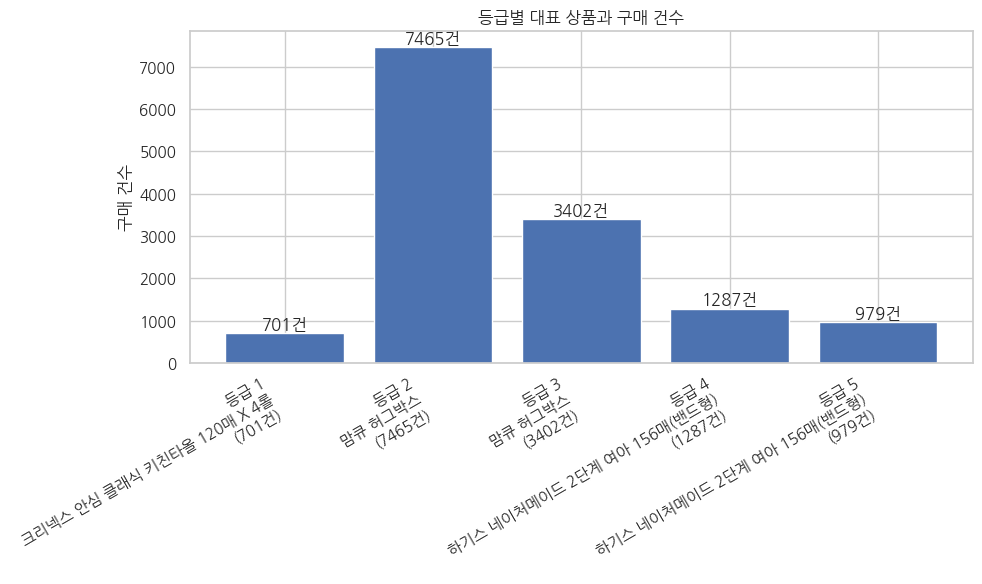

In [130]:
import matplotlib.pyplot as plt

# 등급별로 가장 많이 팔린 상품명과 그 구매 수량 얻기
top_products = df.groupby(['rfm', '상품명']).size().reset_index(name='구매수')
top_products_sorted = top_products.sort_values(['rfm', '구매수'], ascending=[True, False])
top_df = top_products_sorted.groupby('rfm').first().reset_index()

# 라벨 만들기: 등급\n상품명\n(건수)
top_df['라벨'] = '등급 ' + top_df['rfm'].astype(str) + '\n' + top_df['상품명'] + '\n(' + top_df['구매수'].astype(str) + '건)'

# 시각화
plt.figure(figsize=(10, 6))
bars = plt.bar(top_df['라벨'], top_df['구매수'])

plt.title('등급별 대표 상품과 구매 건수')
plt.ylabel('구매 건수')
plt.xticks(rotation=30, ha='right')
plt.tight_layout()

# 바 위에 구매수 표시
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 1, f'{int(yval)}건', ha='center', va='bottom')

plt.show()

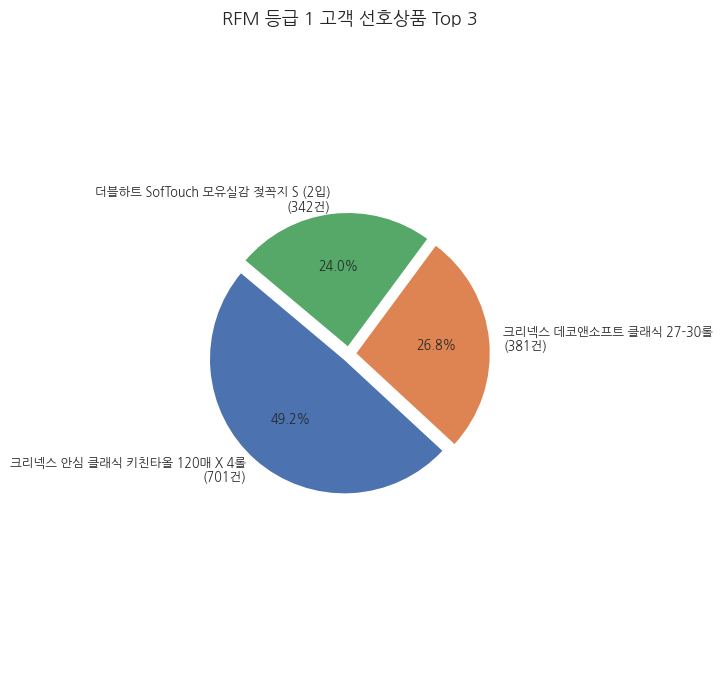

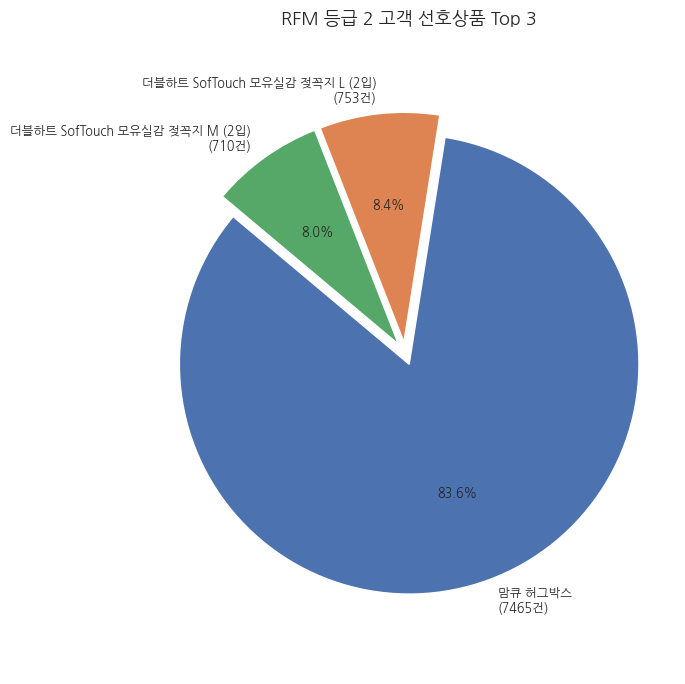

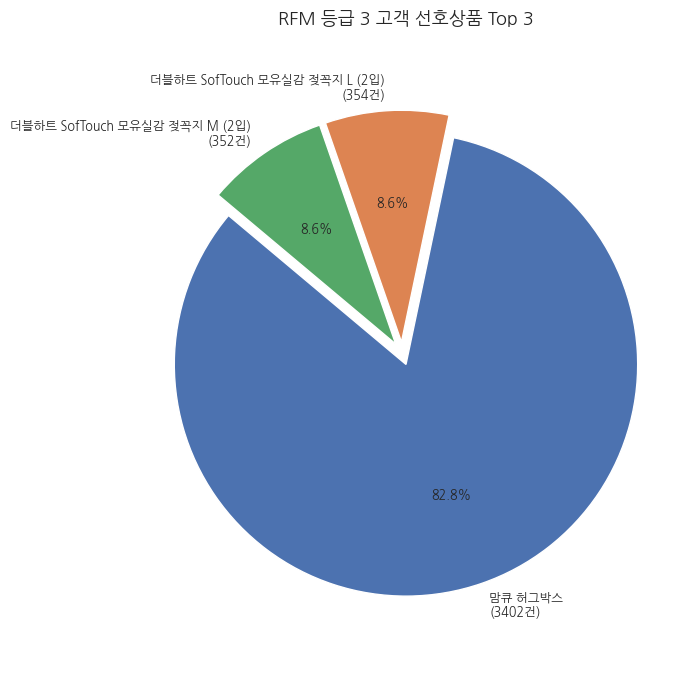

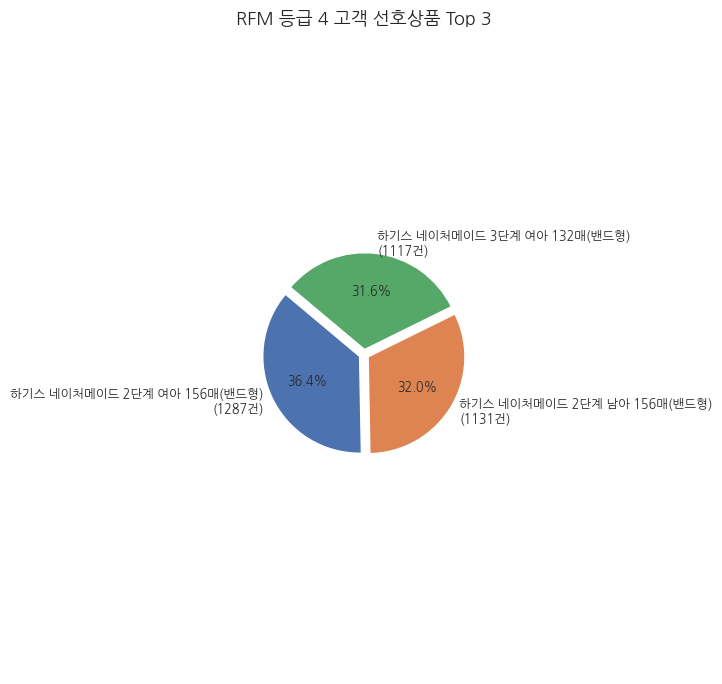

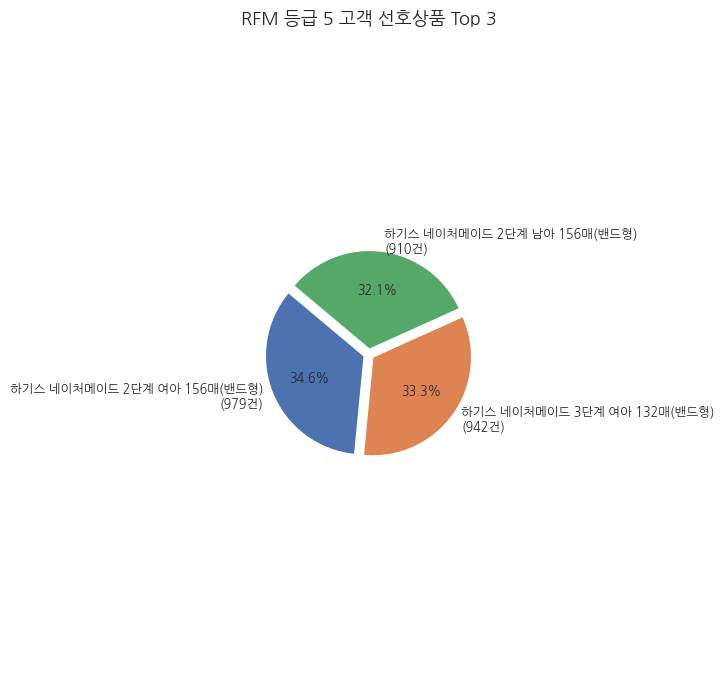

In [131]:
import matplotlib.pyplot as plt

# RFM 등급별로 반복
for rfm_level in sorted(df['rfm'].dropna().unique()):
    df_rfm = df[df['rfm'] == rfm_level]

    # 상품별 구매 건수 상위 3개
    top_items = df_rfm['상품명'].value_counts().head(3)

    # 라벨: 상품명 + 건수
    labels = [f"{item}\n({count}건)" for item, count in zip(top_items.index, top_items.values)]

    explode = [0.05] * len(top_items)  # 조각 살짝 띄우기

    plt.figure(figsize=(7, 7))
    plt.pie(
        top_items,
        labels=labels,
        autopct='%1.1f%%',
        explode=explode,
        startangle=140,
        textprops={'fontsize': 9}
    )
    plt.title(f'RFM 등급 {rfm_level} 고객 선호상품 Top 3', fontsize=13)
    plt.axis('equal')  # 원형 유지
    plt.tight_layout()
    plt.show()

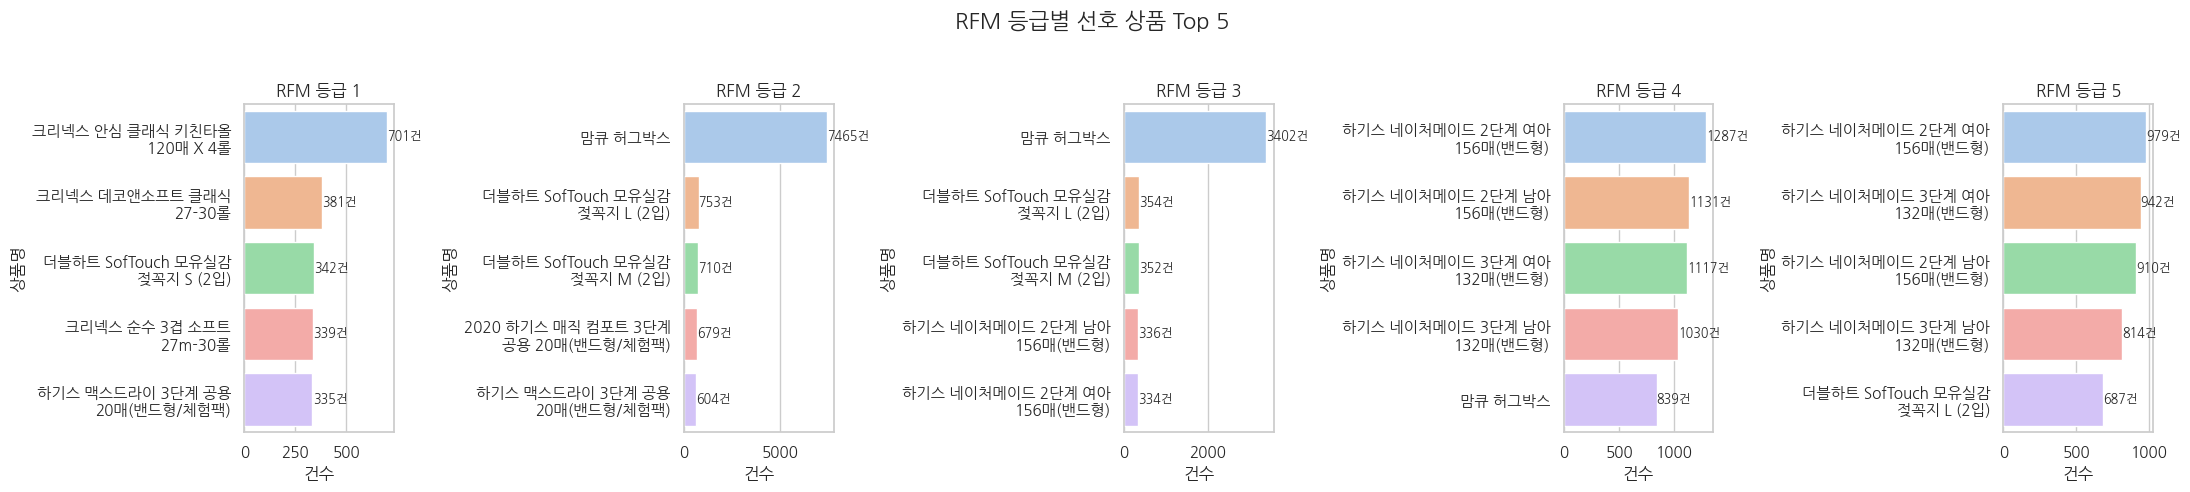

In [132]:
import matplotlib.pyplot as plt
import seaborn as sns
import textwrap

rfm_levels = sorted(df['rfm'].dropna().unique())

fig, axes = plt.subplots(1, len(rfm_levels), figsize=(22, 5), sharey=False)

for i, rfm_level in enumerate(rfm_levels):
    ax = axes[i]
    df_rfm = df[df['rfm'] == rfm_level]

    top5_items = df_rfm['상품명'].value_counts().head(5).reset_index()
    top5_items.columns = ['상품명', '건수']

    # 상품명을 줄바꿈 처리 (20자 단위로 줄바꿈)
    top5_items['상품명'] = top5_items['상품명'].apply(lambda x: '\n'.join(textwrap.wrap(x, width=20)))

    sns.barplot(data=top5_items, x='건수', y='상품명', ax=ax, palette='pastel')

    ax.set_title(f'RFM 등급 {rfm_level}', fontsize=12)
    ax.set_xlabel('건수')
    ax.set_ylabel('상품명')

    # 숫자 표시
    for idx, row in top5_items.iterrows():
        ax.text(row['건수'] + 1, idx, f"{row['건수']}건", va='center', fontsize=9)

plt.suptitle('RFM 등급별 선호 상품 Top 5', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


✅ 1. 등급별 대표 상품 차이 명확

    등급 2~3는 맘큐 허그박스에 구매 집중 (7,465건 → 압도적).

    등급 4~5는 하기스 네이처메이드 기저귀 집중.

    등급 1은 크리넥스 키친타올 등 생활필수품에 국한됨.

➡️ 등급이 높아질수록 유아용 고관여 상품으로 이동

➡️ 등급 2 고객은 특정 기획 상품에 민감 (프로모션 반응성 높음)



✅ 2. RFM 등급별 브랜드 선호 뚜렷

    하기스 브랜드가 전 등급에서 압도적으로 선호됨.

    등급 4, 5 고객은 브랜드 충성도가 높고, 구매량도 많음.

    등급 1~2 고객은 상대적으로 다양한 브랜드 분산 소비.

➡️ 고등급 고객은 특정 브랜드에 충성 → 브랜드 전용 리워드나 VIP 혜택 효과적

➡️ 저등급은 브랜드 유동성 있음 → 다양한 브랜드 체험 기회 제공 전략 가능


✅ 3. 등급 5의 구매금액 비중 압도적

    하기스 브랜드만 약 9.5억 원 소비, 다른 브랜드와 큰 격차

    더블하트/크리넥스/그린핑거/릴리유 순으로 뒤따름

➡️ 상위 고객은 금액도 크고 브랜드 집중도도 높음

➡️ 상위 1% 고객이 매출의 대부분을 차지하는 구조

🎯 1. 고등급 고객 전용 전략 (등급 4, 5)

    하기스 브랜드와 연계한 프리미엄 전용 혜택 or 구독형 모델 제안

    ‘맘큐 허그박스’처럼 묶음/기획 세트를 반복 구매하도록 유도

    결제 등록 카드 & 프로모션 연계 (예: 특정 카드로 결제 시 적립률 2배)

🧲 2. 중저등급 고객 유입 전략 (등급 1~3)

    다양한 브랜드 체험 프로모션 제공 → 브랜드 충성도 높이기

    소액 상품군 중심의 추천 알고리즘 설계

    '체험팩 + 첫 구매 할인' 등 접근성 높이는 정책

🔄 3. 브랜드사와 공동 캠페인

    하기스/더블하트 등과 협업하여 VIP 고객 리텐션 마케팅

    등급 2 고객 대상 맘큐 한정판 or 시즌 한정 기획 상품 확대

💳 4. 카드/결제 기반 분석 연계

    상위 고객이 주로 사용하는 카드사와 제휴하여 타겟 프로모션 설계

    예: “우리카드로 하기스 3만원 이상 결제 시 5천원 캐시백”

# RFM 등급별 선호 브랜드 

In [133]:
# 등급별로 브랜드명 기준으로 몇 번 구매되었는지 집계
brand_by_rfm = df.groupby(['rfm', '브랜드'])['브랜드'].count().reset_index(name='구매수')

# 등급별로 가장 많이 팔린 브랜드만 추출
top_brand_per_rfm = brand_by_rfm.sort_values(['rfm', '구매수'], ascending=[True, False])
top_brand_per_rfm = top_brand_per_rfm.groupby('rfm').first().reset_index()

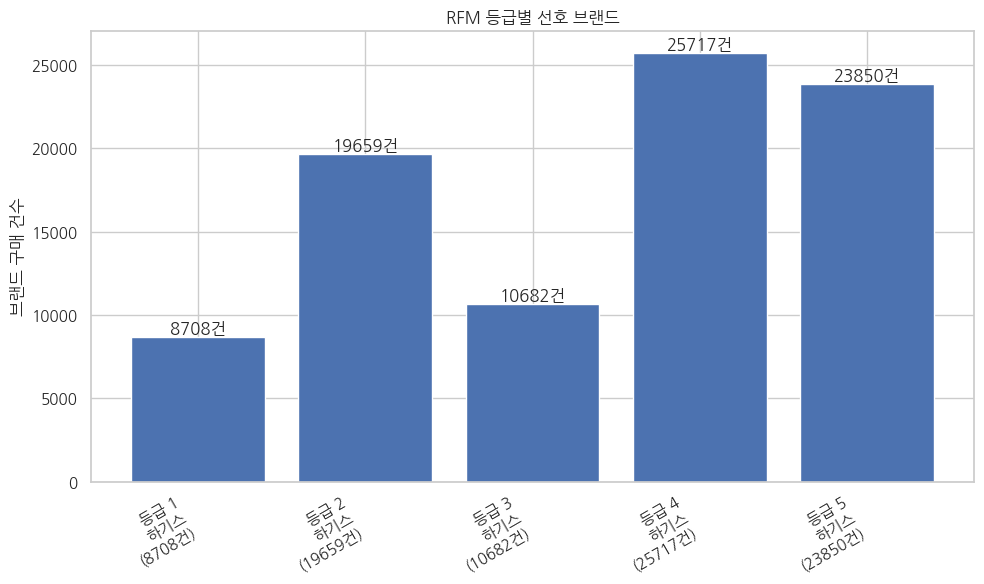

In [134]:
# 라벨: 등급\n브랜드명\n(건수)
top_brand_per_rfm['라벨'] = '등급 ' + top_brand_per_rfm['rfm'].astype(str) + '\n' + \
                            top_brand_per_rfm['브랜드'] + '\n(' + top_brand_per_rfm['구매수'].astype(str) + '건)'

# 시각화
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
bars = plt.bar(top_brand_per_rfm['라벨'], top_brand_per_rfm['구매수'])

plt.title('RFM 등급별 선호 브랜드')
plt.ylabel('브랜드 구매 건수')
plt.xticks(rotation=30, ha='right')
plt.tight_layout()

# 막대 위에 숫자 표시
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 1, f'{int(yval)}건', ha='center', va='bottom')

plt.show()

In [135]:
# 등급별-브랜드별 구매 건수 집계
brand_by_rfm = df.groupby(['rfm', '브랜드'])['브랜드'].count().reset_index(name='구매수')

# 등급별 상위 5개 브랜드만 추출
top5_brands_per_rfm = (
    brand_by_rfm
    .sort_values(['rfm', '구매수'], ascending=[True, False])
    .groupby('rfm')
    .head(5)
)

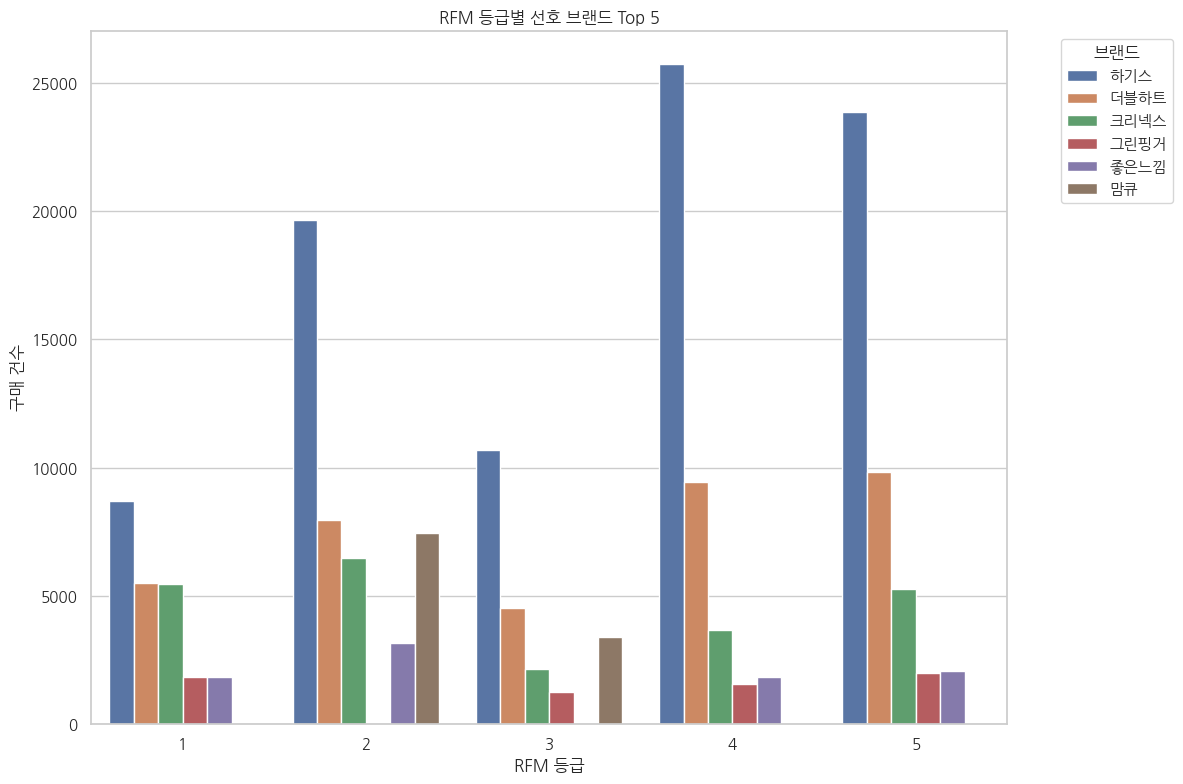

In [136]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
sns.barplot(data=top5_brands_per_rfm, x='rfm', y='구매수', hue='브랜드')

plt.title('RFM 등급별 선호 브랜드 Top 5')
plt.xlabel('RFM 등급')
plt.ylabel('구매 건수')
plt.legend(title='브랜드', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

    브랜드       결제금액
0   하기스  955193130
1  더블하트  187683185
2  크리넥스   85413094
3  그린핑거   26873201
4   릴리유   20477926


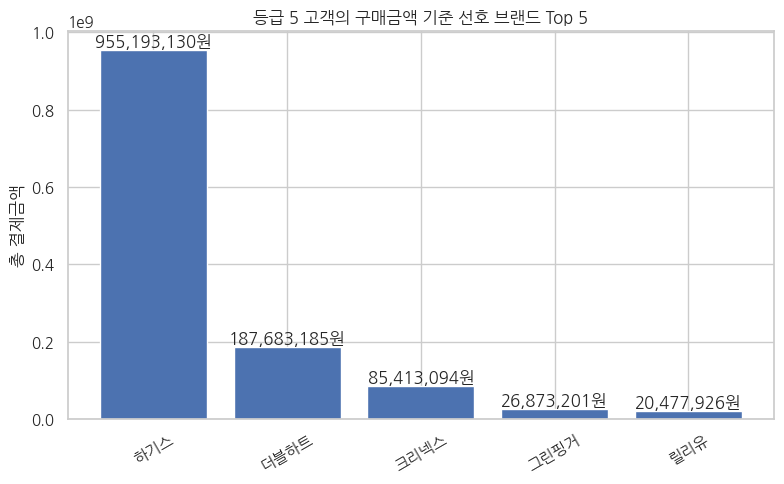

In [137]:
# 예시: 등급 5에서 브랜드별 총 구매 금액 집계
grade = 5  # 원하는 등급 번호로 변경 가능

top_brands_by_money = (
    df[df['rfm'] == grade]
    .groupby('브랜드')['결제금액']
    .sum()
    .sort_values(ascending=False)
    .head(5)
    .reset_index()
)

print(top_brands_by_money)

import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
bars = plt.bar(top_brands_by_money['브랜드'], top_brands_by_money['결제금액'])

plt.title(f'등급 {grade} 고객의 구매금액 기준 선호 브랜드 Top 5')
plt.ylabel('총 결제금액')
plt.xticks(rotation=30)

# 바 위에 금액 표시
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 1000, f'{int(yval):,}원', ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [138]:
grade = 5  # 원하는 등급 번호로 변경 가능

top_brands_by_money = (
    df[df['rfm'] == grade]
    .groupby('브랜드')['결제금액']
    .sum()
    .sort_values(ascending=False)
    .head(5)
    .reset_index()
)
print('grade 5')
print(top_brands_by_money)

grade = 4  # 원하는 등급 번호로 변경 가능

top_brands_by_money = (
    df[df['rfm'] == grade]
    .groupby('브랜드')['결제금액']
    .sum()
    .sort_values(ascending=False)
    .head(5)
    .reset_index()
)
print('grade 4')
print(top_brands_by_money)

grade = 3  # 원하는 등급 번호로 변경 가능

top_brands_by_money = (
    df[df['rfm'] == grade]
    .groupby('브랜드')['결제금액']
    .sum()
    .sort_values(ascending=False)
    .head(5)
    .reset_index()
)
print('grade 3')
print(top_brands_by_money)

grade = 2  # 원하는 등급 번호로 변경 가능

top_brands_by_money = (
    df[df['rfm'] == grade]
    .groupby('브랜드')['결제금액']
    .sum()
    .sort_values(ascending=False)
    .head(5)
    .reset_index()
)
print('grade 2')
print(top_brands_by_money)

grade = 1  # 원하는 등급 번호로 변경 가능

top_brands_by_money = (
    df[df['rfm'] == grade]
    .groupby('브랜드')['결제금액']
    .sum()
    .sort_values(ascending=False)
    .head(5)
    .reset_index()
)
print('grade 1')
print(top_brands_by_money)

grade 5
    브랜드       결제금액
0   하기스  955193130
1  더블하트  187683185
2  크리넥스   85413094
3  그린핑거   26873201
4   릴리유   20477926
grade 4
    브랜드       결제금액
0   하기스  957828146
1  더블하트  180686155
2  크리넥스   46179978
3  그린핑거   20789542
4  좋은느낌   14703791
grade 3
    브랜드       결제금액
0   하기스  349643046
1  더블하트   74432207
2  크리넥스   26799377
3  그린핑거   15839332
4    맘큐   10206000
grade 2
    브랜드       결제금액
0   하기스  470935925
1  더블하트  112063493
2  크리넥스   64177947
3  그린핑거   34083648
4    맘큐   22395000
grade 1
    브랜드       결제금액
0   하기스  189434718
1  더블하트   87800059
2  크리넥스   53503468
3  그린핑거   26365903
4   릴리유   13752320


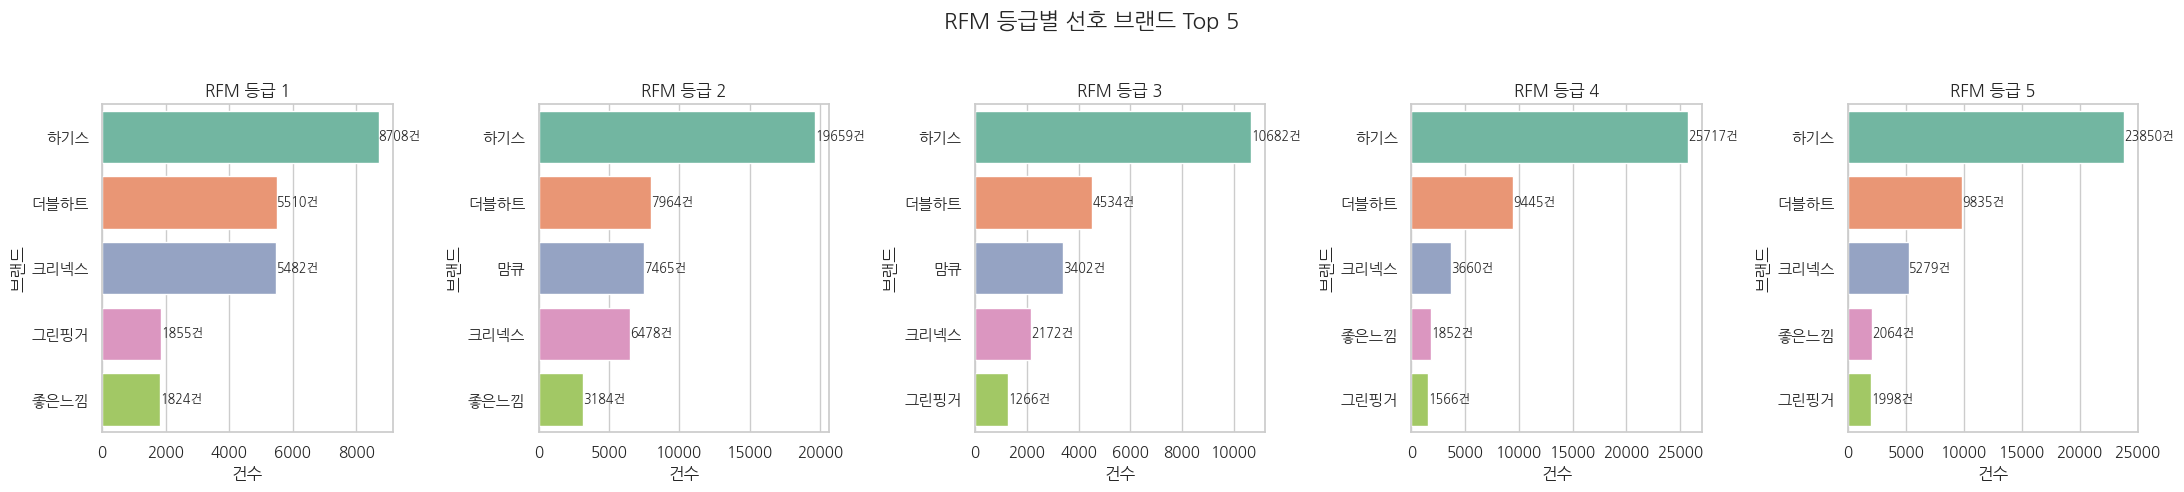

In [139]:
import matplotlib.pyplot as plt
import seaborn as sns
import textwrap


rfm_levels = sorted(df['rfm'].dropna().unique())

fig, axes = plt.subplots(1, len(rfm_levels), figsize=(22, 5), sharey=False)

for i, rfm_level in enumerate(rfm_levels):
    ax = axes[i]
    df_rfm = df[df['rfm'] == rfm_level]

    # 브랜드별 구매 건수 상위 5개
    top5_brands = df_rfm['브랜드'].value_counts().head(5).reset_index()
    top5_brands.columns = ['브랜드', '건수']

    # 브랜드명 줄바꿈 처리 (15자마다 줄바꿈)
    top5_brands['브랜드'] = top5_brands['브랜드'].apply(lambda x: '\n'.join(textwrap.wrap(x, width=15)))

    sns.barplot(data=top5_brands, x='건수', y='브랜드', ax=ax, palette='Set2')

    ax.set_title(f'RFM 등급 {rfm_level}', fontsize=12)
    ax.set_xlabel('건수')
    ax.set_ylabel('브랜드')

    # 막대 옆에 숫자 표시
    for idx, row in top5_brands.iterrows():
        ax.text(row['건수'] + 1, idx, f"{row['건수']}건", va='center', fontsize=9)

plt.suptitle('RFM 등급별 선호 브랜드 Top 5', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# RFM 등급별 결제카드

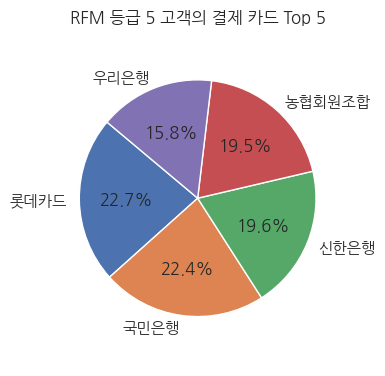

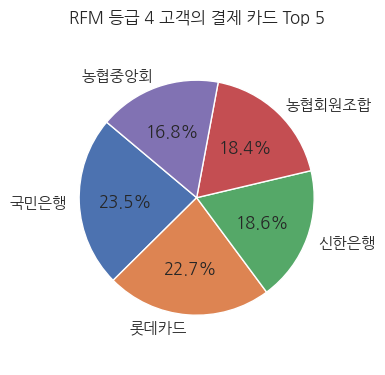

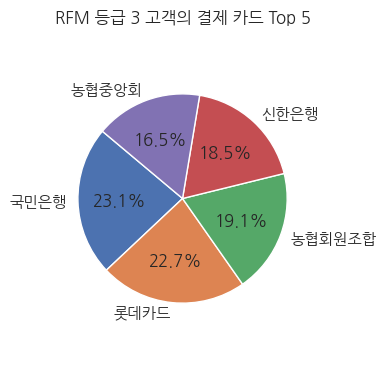

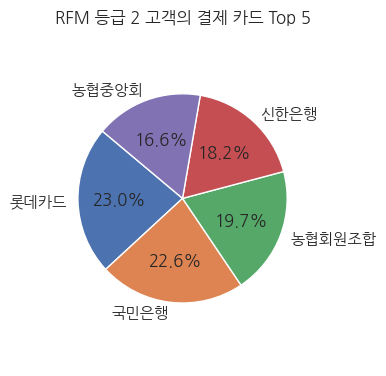

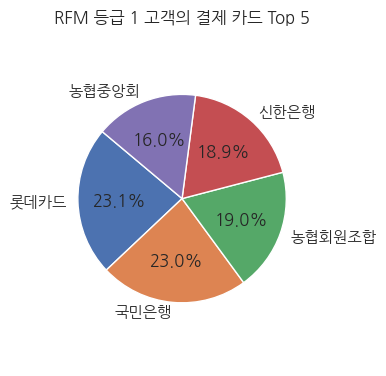

In [140]:
import matplotlib.pyplot as plt

# 등급 설정 (예: 등급 5)
grade = 5

# 등급별 카드사별 결제 건수 집계
card_count = (
    df[df['rfm'] == grade]
    .groupby('결제등록카드')
    .size()
    .sort_values(ascending=False)
    .head(5)
)

# 파이 차트
plt.figure(figsize=(4, 4))
plt.pie(card_count, labels=card_count.index, autopct='%1.1f%%', startangle=140)
plt.title(f'RFM 등급 {grade} 고객의 결제 카드 Top 5')
plt.axis('equal')  # 원형으로 표시
plt.tight_layout()
plt.show()

grade = 4

# 등급별 카드사별 결제 건수 집계
card_count = (
    df[df['rfm'] == grade]
    .groupby('결제등록카드')
    .size()
    .sort_values(ascending=False)
    .head(5)
)

# 파이 차트
plt.figure(figsize=(4, 4))
plt.pie(card_count, labels=card_count.index, autopct='%1.1f%%', startangle=140)
plt.title(f'RFM 등급 {grade} 고객의 결제 카드 Top 5')
plt.axis('equal')  # 원형으로 표시
plt.tight_layout()
plt.show()

grade = 3

# 등급별 카드사별 결제 건수 집계
card_count = (
    df[df['rfm'] == grade]
    .groupby('결제등록카드')
    .size()
    .sort_values(ascending=False)
    .head(5)
)

# 파이 차트
plt.figure(figsize=(4, 4))
plt.pie(card_count, labels=card_count.index, autopct='%1.1f%%', startangle=140)
plt.title(f'RFM 등급 {grade} 고객의 결제 카드 Top 5')
plt.axis('equal')  # 원형으로 표시
plt.tight_layout()
plt.show()

grade = 2

# 등급별 카드사별 결제 건수 집계
card_count = (
    df[df['rfm'] == grade]
    .groupby('결제등록카드')
    .size()
    .sort_values(ascending=False)
    .head(5)
)

# 파이 차트
plt.figure(figsize=(4, 4))
plt.pie(card_count, labels=card_count.index, autopct='%1.1f%%', startangle=140)
plt.title(f'RFM 등급 {grade} 고객의 결제 카드 Top 5')
plt.axis('equal')  # 원형으로 표시
plt.tight_layout()
plt.show()


grade = 1

# 등급별 카드사별 결제 건수 집계
card_count = (
    df[df['rfm'] == grade]
    .groupby('결제등록카드')
    .size()
    .sort_values(ascending=False)
    .head(5)
)

# 파이 차트
plt.figure(figsize=(4, 4))
plt.pie(card_count, labels=card_count.index, autopct='%1.1f%%', startangle=140)
plt.title(f'RFM 등급 {grade} 고객의 결제 카드 Top 5')
plt.axis('equal')  # 원형으로 표시
plt.tight_layout()
plt.show()

In [141]:
# 등급별 카드명 기준 결제 건수 집계
card_counts = (
    df.groupby(['rfm', '결제등록카드'])
    .size()
    .reset_index(name='결제건수')
)

# 등급별 상위 3개 카드 추출
top3_cards_per_rfm = (
    card_counts
    .sort_values(['rfm', '결제건수'], ascending=[True, False])
    .groupby('rfm')
    .head(3)
)

# 보기 좋게 출력
for rfm_level in sorted(top3_cards_per_rfm['rfm'].unique()):
    print(f"\n✅ RFM 등급 {rfm_level} 고객의 결제 카드 Top 3:")
    temp = top3_cards_per_rfm[top3_cards_per_rfm['rfm'] == rfm_level]
    for idx, row in temp.iterrows():
        print(f"   - {row['결제등록카드']}: {row['결제건수']}건")


✅ RFM 등급 1 고객의 결제 카드 Top 3:
   - 롯데카드: 2647건
   - 국민은행: 2634건
   - 농협회원조합: 2173건

✅ RFM 등급 2 고객의 결제 카드 Top 3:
   - 롯데카드: 3860건
   - 국민은행: 3793건
   - 농협회원조합: 3308건

✅ RFM 등급 3 고객의 결제 카드 Top 3:
   - 국민은행: 2251건
   - 롯데카드: 2211건
   - 농협회원조합: 1861건

✅ RFM 등급 4 고객의 결제 카드 Top 3:
   - 국민은행: 4816건
   - 롯데카드: 4652건
   - 신한은행: 3797건

✅ RFM 등급 5 고객의 결제 카드 Top 3:
   - 롯데카드: 4699건
   - 국민은행: 4639건
   - 신한은행: 4047건


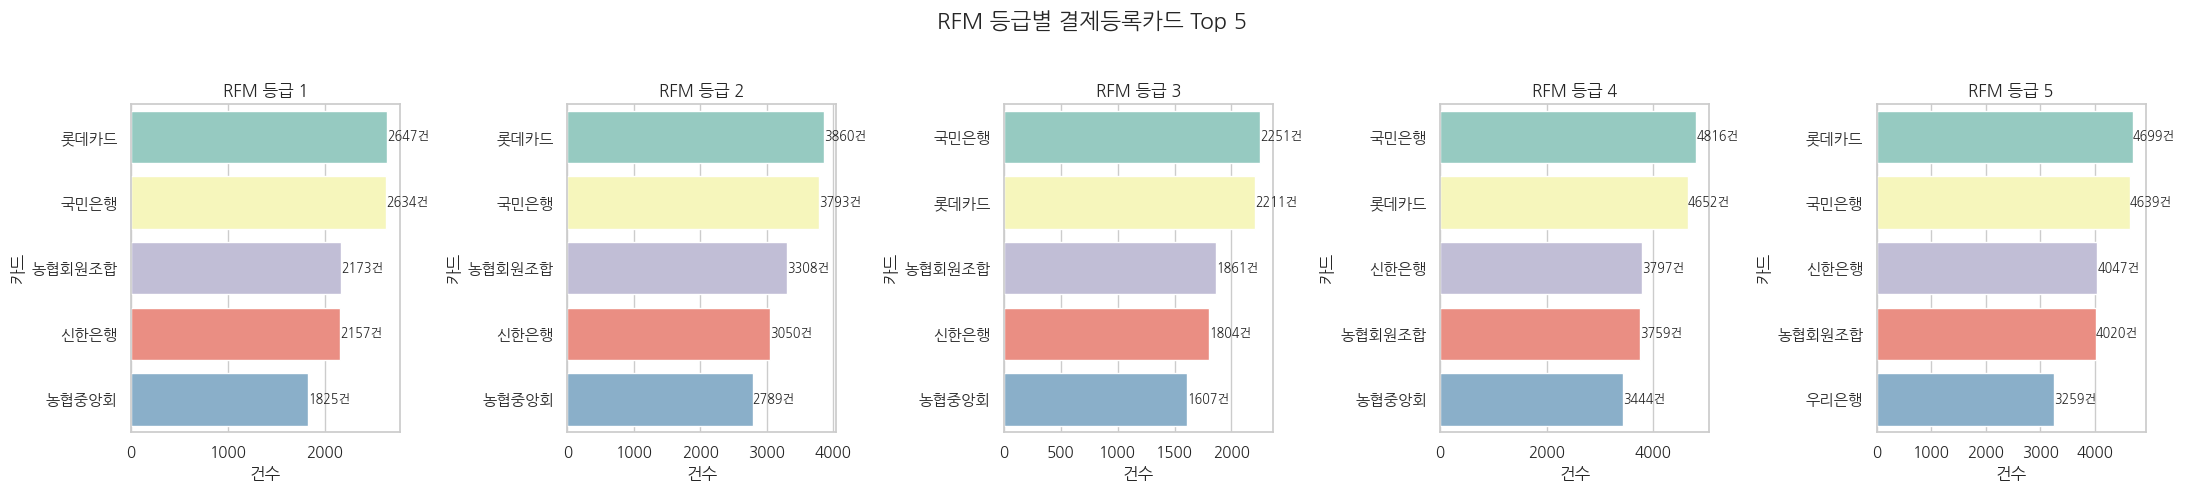

In [142]:
import matplotlib.pyplot as plt
import seaborn as sns
import textwrap


rfm_levels = sorted(df['rfm'].dropna().unique())

fig, axes = plt.subplots(1, len(rfm_levels), figsize=(22, 5), sharey=False)

for i, rfm_level in enumerate(rfm_levels):
    ax = axes[i]
    df_rfm = df[df['rfm'] == rfm_level]

    # 카드별 구매 건수 상위 5개
    top5_cards = df_rfm['결제등록카드'].value_counts().head(5).reset_index()
    top5_cards.columns = ['카드', '건수']

    # 카드명 줄바꿈 처리 (15자마다)
    top5_cards['카드'] = top5_cards['카드'].apply(lambda x: '\n'.join(textwrap.wrap(str(x), width=15)))

    sns.barplot(data=top5_cards, x='건수', y='카드', ax=ax, palette='Set3')

    ax.set_title(f'RFM 등급 {rfm_level}', fontsize=12)
    ax.set_xlabel('건수')
    ax.set_ylabel('카드')

    # 숫자 표시
    for idx, row in top5_cards.iterrows():
        ax.text(row['건수'] + 1, idx, f"{row['건수']}건", va='center', fontsize=9)

plt.suptitle('RFM 등급별 결제등록카드 Top 5', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# 등급별 결제등록카드와 프로모션

In [143]:
print(df[['상품명', '브랜드', '프로모션']].drop_duplicates().head(10))

                                                  상품명   브랜드     프로모션
0                          크리넥스 3겹 순수 소프트 27m 30롤 X 2  크리넥스  프로모션 없음
1                          하기스 맥스드라이 2단계 공용 156매(밴드형)   하기스  프로모션 없음
2   좋은느낌 에어핏쿠션 울트라 날개 중형 18개입X2 + 슬림 날개 수퍼롱 오버나이트 ...  좋은느낌  프로모션 없음
3                     하기스 네이처메이드 이른둥이기저귀 중형 150매(밴드형)   하기스  프로모션 없음
4              더블하트 젖병세정제 거품형 700ml(용기) + 650ml(리필)X3  더블하트  프로모션 없음
5               더블하트 SofTouch 모유실감 노꼭지 트윈팩 240ml(오렌지)  더블하트  프로모션 없음
7                                      더블하트 이유식 조리기세트  더블하트  프로모션 없음
10                  더블하트 SofTouch 모유실감 젖꼭지 L (2입) x 2  더블하트  프로모션 없음
11                      더블하트 SofTouch 모유실감 젖꼭지 S (2입)  더블하트  프로모션 없음
12                              더블하트 소프트 허니콤 수유패드 96매  더블하트  프로모션 없음


In [144]:
print(df['프로모션'].value_counts())

프로모션 없음    193988
증정           3813
1+1          1150
쿠폰적용할인        596
기획전           148
핫딜             67
Name: 프로모션, dtype: int64


In [145]:
df['프로모션'] = df['프로모션'].astype(str).str.strip()

df_valid = df.dropna(subset=['rfm', '결제등록카드', '프로모션'])


rfm_card_promo = (
    df_valid.groupby(['rfm', '결제등록카드', '프로모션'])
    .size()
    .reset_index(name='건수')
)

In [146]:
for rfm_level in sorted(rfm_card_promo['rfm'].unique()):
    print(f"\n📊 RFM 등급 {rfm_level} 고객 - 결제카드 × 프로모션 유형 분석:")
    temp = rfm_card_promo[rfm_card_promo['rfm'] == rfm_level]
    for card in temp['결제등록카드'].unique():
        sub = temp[temp['결제등록카드'] == card]
        for _, row in sub.iterrows():
            print(f"   - {card} / {row['프로모션']}: {row['건수']}건")


📊 RFM 등급 1 고객 - 결제카드 × 프로모션 유형 분석:
   - BC카드 / 1+1: 13건
   - BC카드 / 쿠폰적용할인: 15건
   - BC카드 / 프로모션 없음: 572건
   - SC제일은행 / 1+1: 11건
   - SC제일은행 / 증정: 1건
   - SC제일은행 / 쿠폰적용할인: 2건
   - SC제일은행 / 프로모션 없음: 214건
   - 경남은행 / 1+1: 1건
   - 경남은행 / 쿠폰적용할인: 1건
   - 경남은행 / 프로모션 없음: 56건
   - 광주은행 / 1+1: 5건
   - 광주은행 / 쿠폰적용할인: 3건
   - 광주은행 / 프로모션 없음: 253건
   - 국민은행 / 1+1: 64건
   - 국민은행 / 증정: 8건
   - 국민은행 / 쿠폰적용할인: 28건
   - 국민은행 / 프로모션 없음: 2534건
   - 국민카드 / 1+1: 9건
   - 국민카드 / 증정: 1건
   - 국민카드 / 쿠폰적용할인: 12건
   - 국민카드 / 프로모션 없음: 814건
   - 기업은행 / 1+1: 13건
   - 기업은행 / 증정: 1건
   - 기업은행 / 쿠폰적용할인: 10건
   - 기업은행 / 프로모션 없음: 602건
   - 농협중앙회 / 1+1: 31건
   - 농협중앙회 / 증정: 5건
   - 농협중앙회 / 쿠폰적용할인: 24건
   - 농협중앙회 / 프로모션 없음: 1765건
   - 농협회원조합 / 1+1: 42건
   - 농협회원조합 / 증정: 5건
   - 농협회원조합 / 쿠폰적용할인: 22건
   - 농협회원조합 / 프로모션 없음: 2104건
   - 대구은행 / 1+1: 2건
   - 대구은행 / 프로모션 없음: 102건
   - 롯데카드 / 1+1: 60건
   - 롯데카드 / 증정: 7건
   - 롯데카드 / 쿠폰적용할인: 25건
   - 롯데카드 / 프로모션 없음: 2555건
   - 미래에셋증권 / 1+1: 2건
   - 미래에셋증권 / 쿠폰적용할인: 1건
   - 미래에셋증권

In [147]:
rfm_card_promo = (
    df_valid.groupby(['rfm', '결제등록카드', '프로모션'])
    .size()
    .reset_index(name='건수')
)

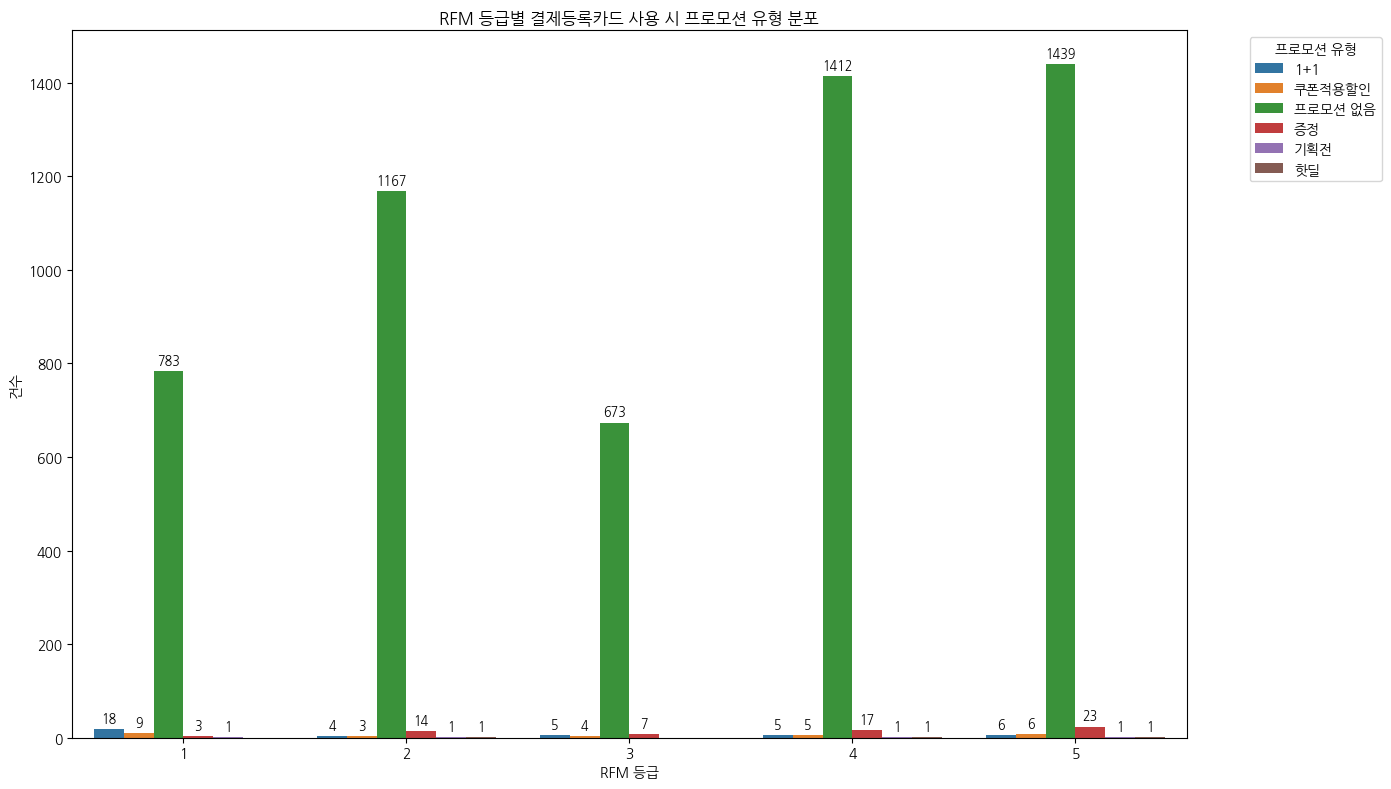

In [59]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(14, 8))

barplot = sns.barplot(
    data=rfm_card_promo,
    x='rfm',
    y='건수',
    hue='프로모션',
    ci=None
)

plt.title('RFM 등급별 결제등록카드 사용 시 프로모션 유형 분포')
plt.xlabel('RFM 등급')
plt.ylabel('건수')
plt.legend(title='프로모션 유형', bbox_to_anchor=(1.05, 1), loc='upper left')

# 막대 위에 숫자 표시
for bar in barplot.patches:
    height = bar.get_height()
    if height > 0:
        barplot.annotate(f'{int(height)}',
                         xy=(bar.get_x() + bar.get_width() / 2, height),
                         xytext=(0, 3),  # 위로 약간 띄우기
                         textcoords='offset points',
                         ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()


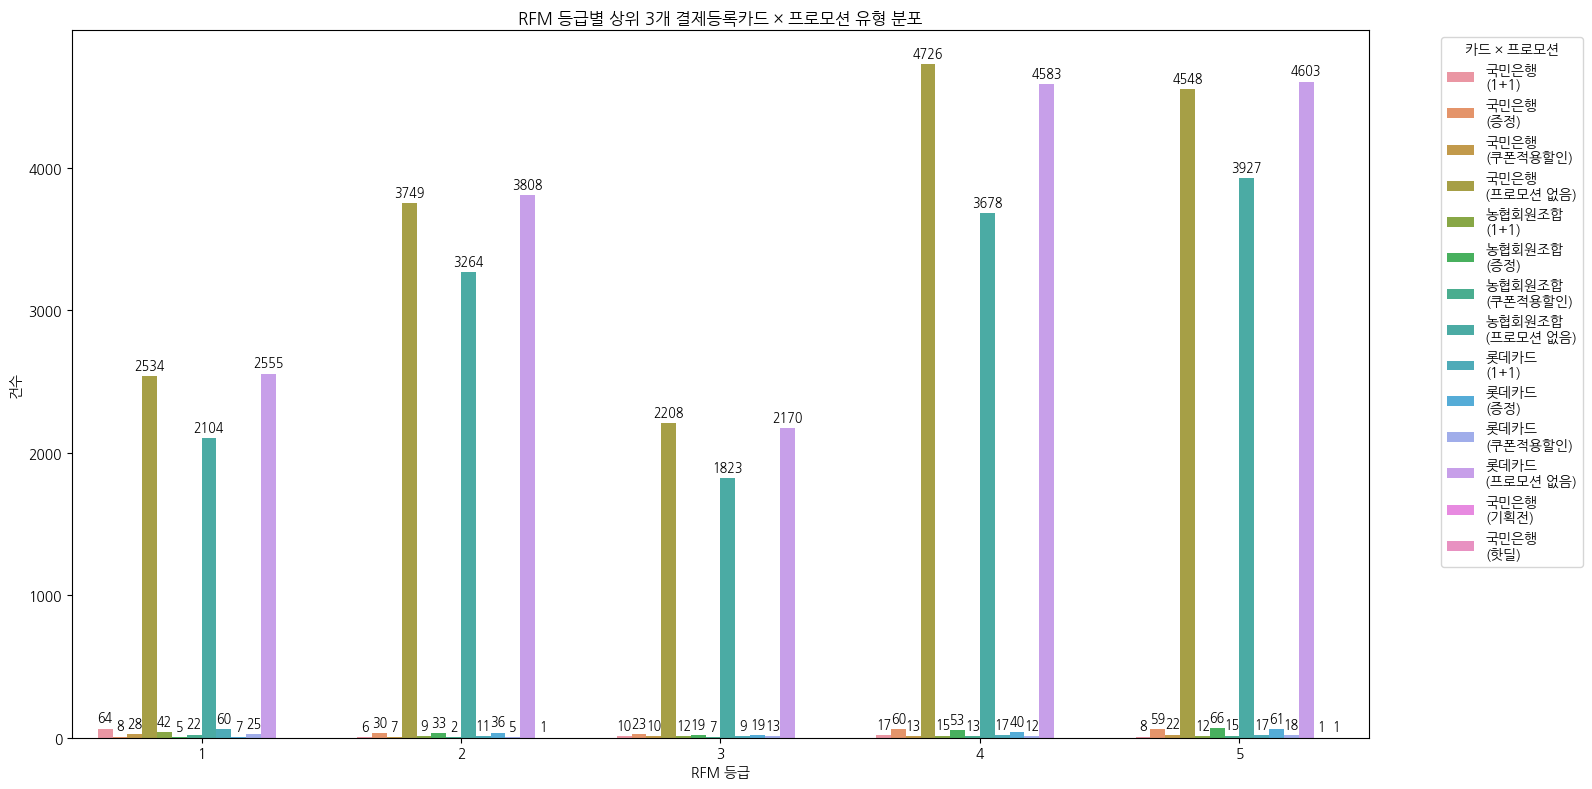

In [61]:
import matplotlib.pyplot as plt
import seaborn as sns

# 카드 + 프로모션 결합하여 라벨 생성
rfm_card_promo_top3['카드_프로모션'] = (
    rfm_card_promo_top3['결제등록카드'] + '\n(' + rfm_card_promo_top3['프로모션'] + ')'
)

plt.figure(figsize=(16, 8))

# hue를 카드_프로모션로 구분
barplot = sns.barplot(
    data=rfm_card_promo_top3,
    x='rfm',
    y='건수',
    hue='카드_프로모션',
    ci=None
)

plt.title('RFM 등급별 상위 3개 결제등록카드 × 프로모션 유형 분포')
plt.xlabel('RFM 등급')
plt.ylabel('건수')
plt.legend(title='카드 × 프로모션', bbox_to_anchor=(1.05, 1), loc='upper left')

# 막대 위에 숫자 표시
for bar in barplot.patches:
    height = bar.get_height()
    if height > 0:
        barplot.annotate(f'{int(height)}',
                         xy=(bar.get_x() + bar.get_width() / 2, height),
                         xytext=(0, 3),
                         textcoords='offset points',
                         ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

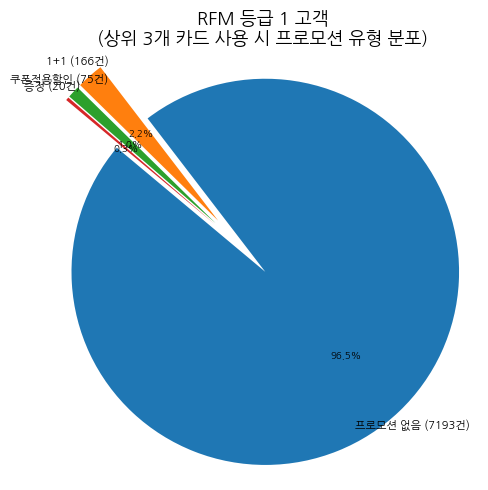

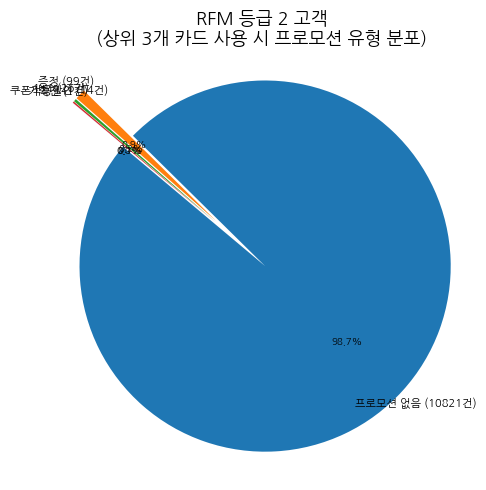

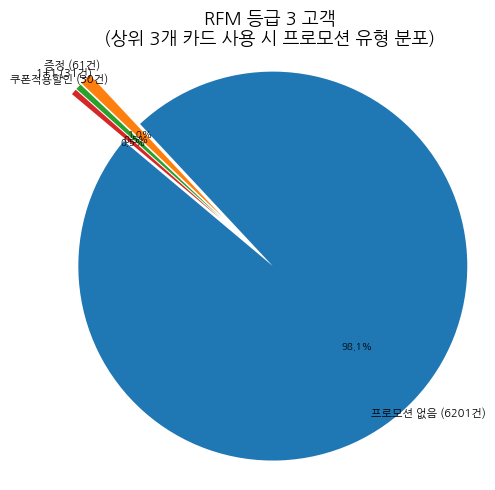

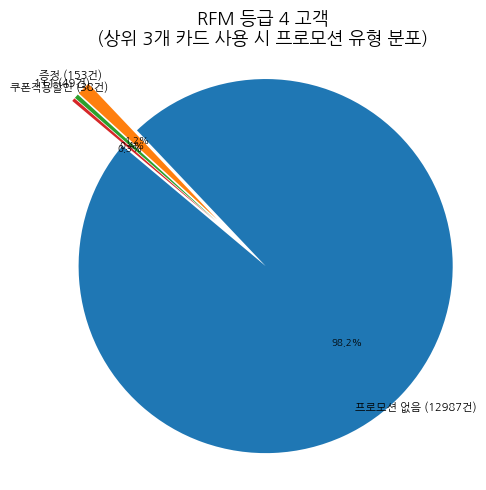

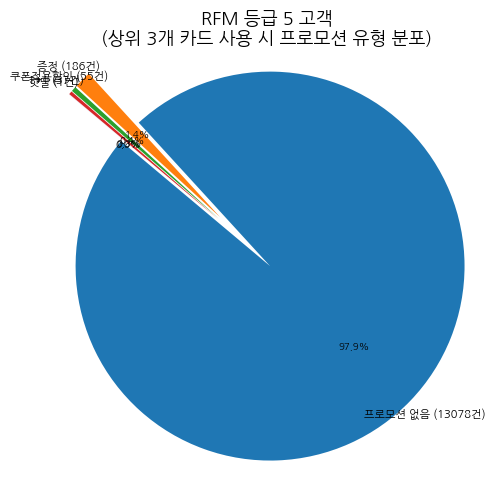

In [74]:
import matplotlib.pyplot as plt

# 상위 3개 카드 추출
top3_cards = df['결제등록카드'].value_counts().head(3).index

# 유효한 데이터만 추출
df_valid = df.dropna(subset=['rfm', '결제등록카드', '프로모션'])
df_top3 = df_valid[df_valid['결제등록카드'].isin(top3_cards)]

# 등급별로 파이차트 출력
for rfm_level in sorted(df_top3['rfm'].unique()):
    df_sub = df_top3[df_top3['rfm'] == rfm_level]
    
    # 프로모션별 집계 (상위 5개까지만)
    promo_counts = df_sub['프로모션'].value_counts().head(5)
    
    labels = [f"{label} ({count}건)" for label, count in zip(promo_counts.index, promo_counts.values)]

    # 각 wedge에 대해 라벨을 조금 바깥쪽에 표시
    explode = [0.18] * len(promo_counts)  # 모든 조각을 조금씩 띄움

    plt.figure(figsize=(5, 5))
    wedges, texts, autotexts = plt.pie(
        promo_counts,
        labels=labels,
        autopct='%1.1f%%',
        startangle=140,
        explode=explode,
        textprops=dict(color="black", fontsize=9)
    )

    # 라벨 텍스트와 퍼센트 텍스트 간격 조정
    for text in texts:
        text.set_horizontalalignment('center')
        text.set_fontsize(8)
    for autotext in autotexts:
        autotext.set_fontsize(7)

    plt.title(f'RFM 등급 {rfm_level} 고객\n(상위 3개 카드 사용 시 프로모션 유형 분포)', fontsize=13)
    plt.axis('equal')
    plt.tight_layout()
    plt.show()

In [78]:
# 할인률 = (정상가 - 결제금액) / 정상가
df['할인률'] = (df['구매금액'] - df['결제금액']) / df['구매금액']

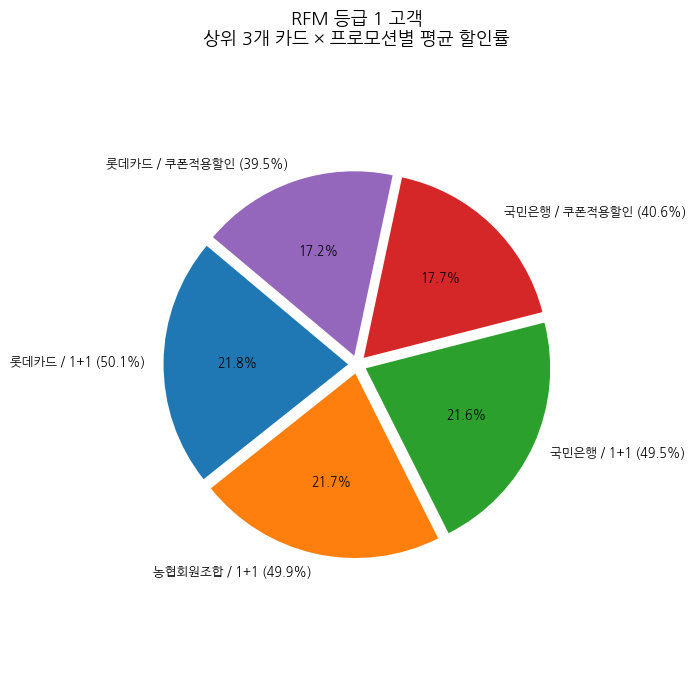

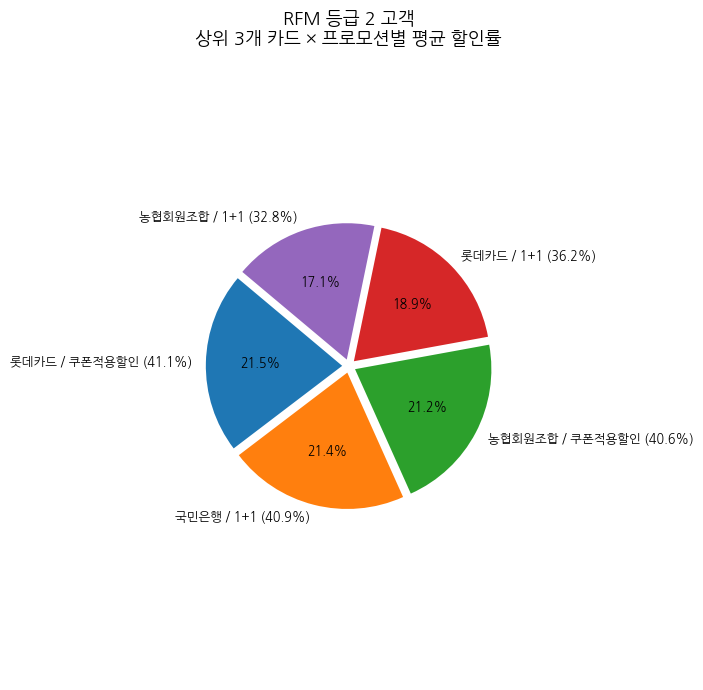

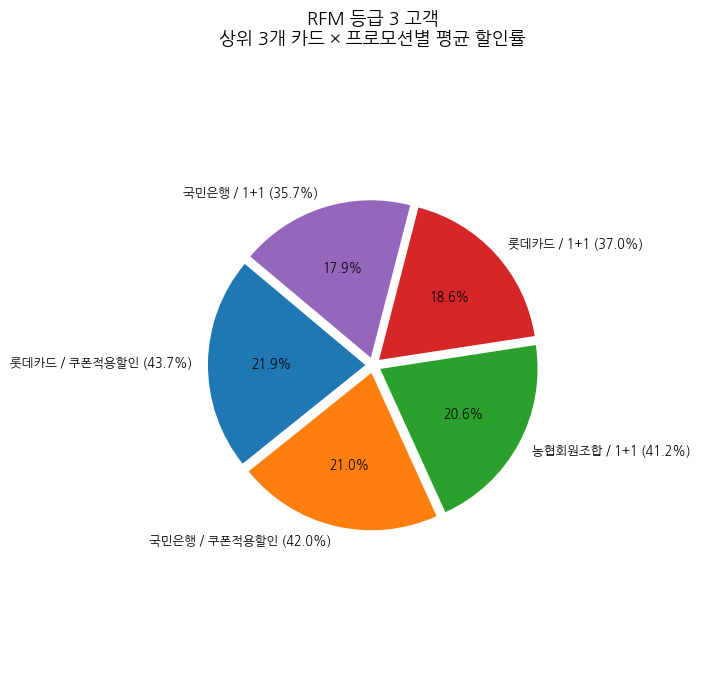

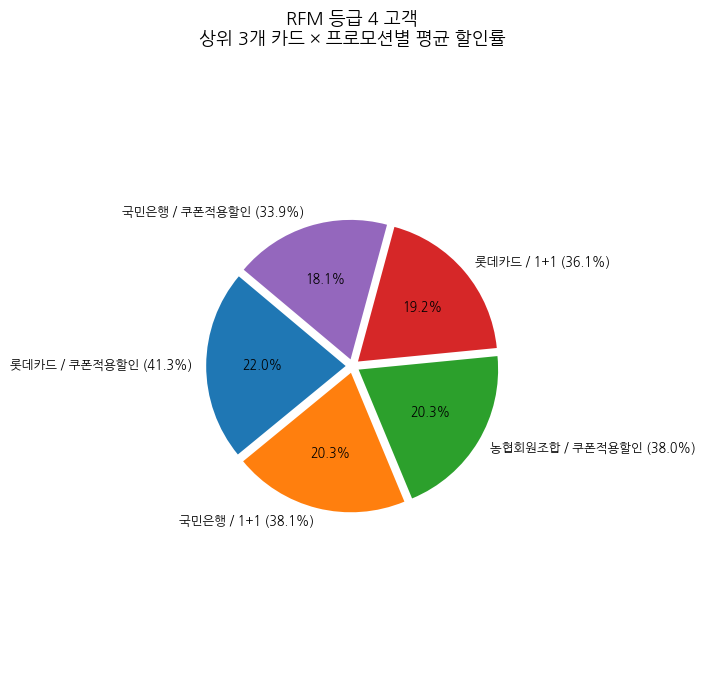

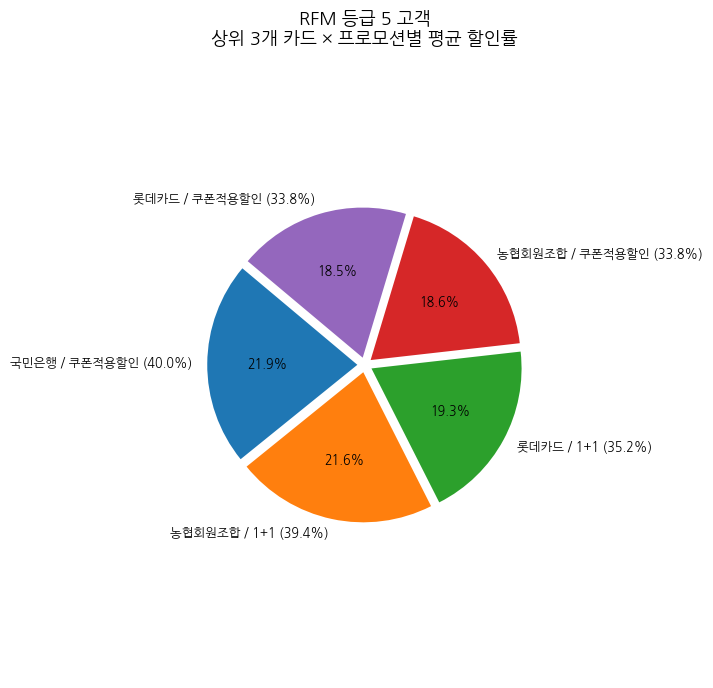

In [83]:
import matplotlib.pyplot as plt

# 할인률 계산 (이미 있으면 생략)
df['할인률'] = (df['구매금액'] - df['결제금액']) / df['구매금액']
df['할인률'] = df['할인률'].fillna(0)

# 상위 3개 카드 기준 + 프로모션 적용된 거래만
top3_cards = df['결제등록카드'].value_counts().head(3).index
df_valid = df[
    (df['결제등록카드'].isin(top3_cards)) & 
    (df['프로모션'] != '프로모션 없음') & 
    df['할인률'].notna()
]

# 등급별 파이차트
for rfm_level in sorted(df_valid['rfm'].unique()):
    df_sub = df_valid[df_valid['rfm'] == rfm_level]

    # 카드 + 프로모션별 평균 할인률 집계
    group = df_sub.groupby(['결제등록카드', '프로모션'])['할인률'].mean()
    group = group.sort_values(ascending=False).head(5)

    # 라벨 구성
    labels = [
        f"{card} / {promo} ({round(rate*100, 1)}%)"
        for (card, promo), rate in group.items()
    ]

    explode = [0.05] * len(group)

    plt.figure(figsize=(7, 7))
    plt.pie(
        group,
        labels=labels,
        autopct='%1.1f%%',
        startangle=140,
        explode=explode,
        textprops=dict(fontsize=9)
    )
    plt.title(f'RFM 등급 {rfm_level} 고객\n상위 3개 카드 × 프로모션별 평균 할인률', fontsize=13)
    plt.axis('equal')
    plt.tight_layout()
    plt.show()

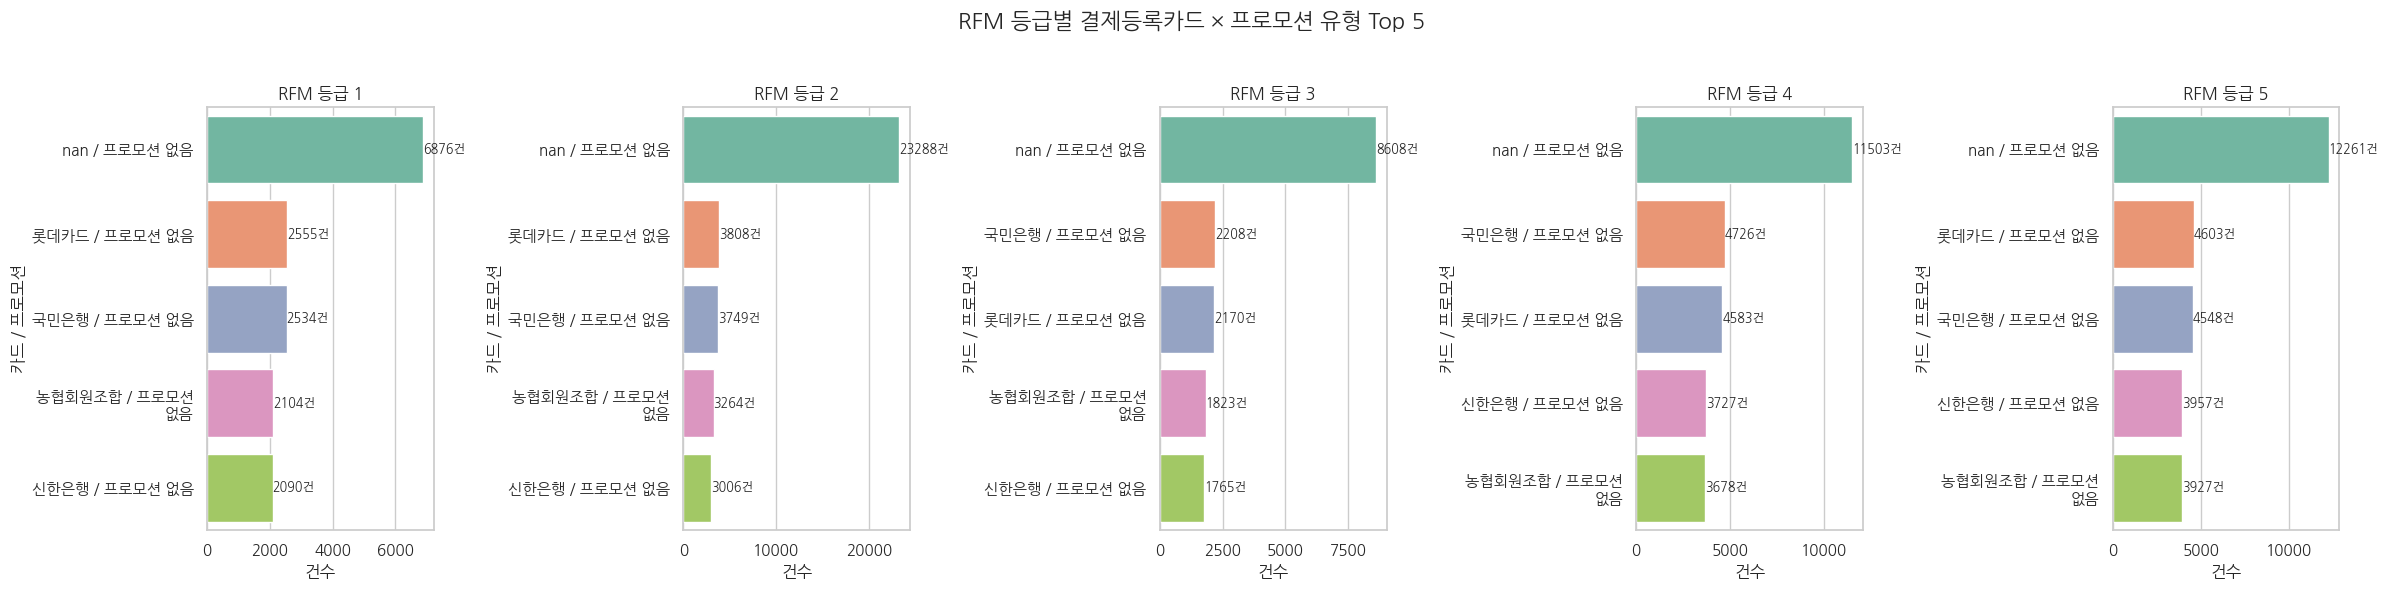

In [148]:
import matplotlib.pyplot as plt
import seaborn as sns
import textwrap

# 카드 + 프로모션 조합을 하나의 라벨로 합침
df['카드_프로모션'] = df['결제등록카드'].astype(str) + ' / ' + df['프로모션'].astype(str)

rfm_levels = sorted(df['rfm'].dropna().unique())

fig, axes = plt.subplots(1, len(rfm_levels), figsize=(24, 6), sharey=False)

for i, rfm_level in enumerate(rfm_levels):
    ax = axes[i]
    df_rfm = df[df['rfm'] == rfm_level]

    # 카드+프로모션 조합별 상위 5개
    top5_combo = df_rfm['카드_프로모션'].value_counts().head(5).reset_index()
    top5_combo.columns = ['카드_프로모션', '건수']

    # 줄바꿈 처리 (15자 기준)
    top5_combo['카드_프로모션'] = top5_combo['카드_프로모션'].apply(lambda x: '\n'.join(textwrap.wrap(x, width=15)))

    sns.barplot(data=top5_combo, x='건수', y='카드_프로모션', ax=ax, palette='Set2')

    ax.set_title(f'RFM 등급 {rfm_level}', fontsize=12)
    ax.set_xlabel('건수')
    ax.set_ylabel('카드 / 프로모션')

    # 숫자 표기
    for idx, row in top5_combo.iterrows():
        ax.text(row['건수'] + 1, idx, f"{row['건수']}건", va='center', fontsize=9)

plt.suptitle('RFM 등급별 결제등록카드 × 프로모션 유형 Top 5', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


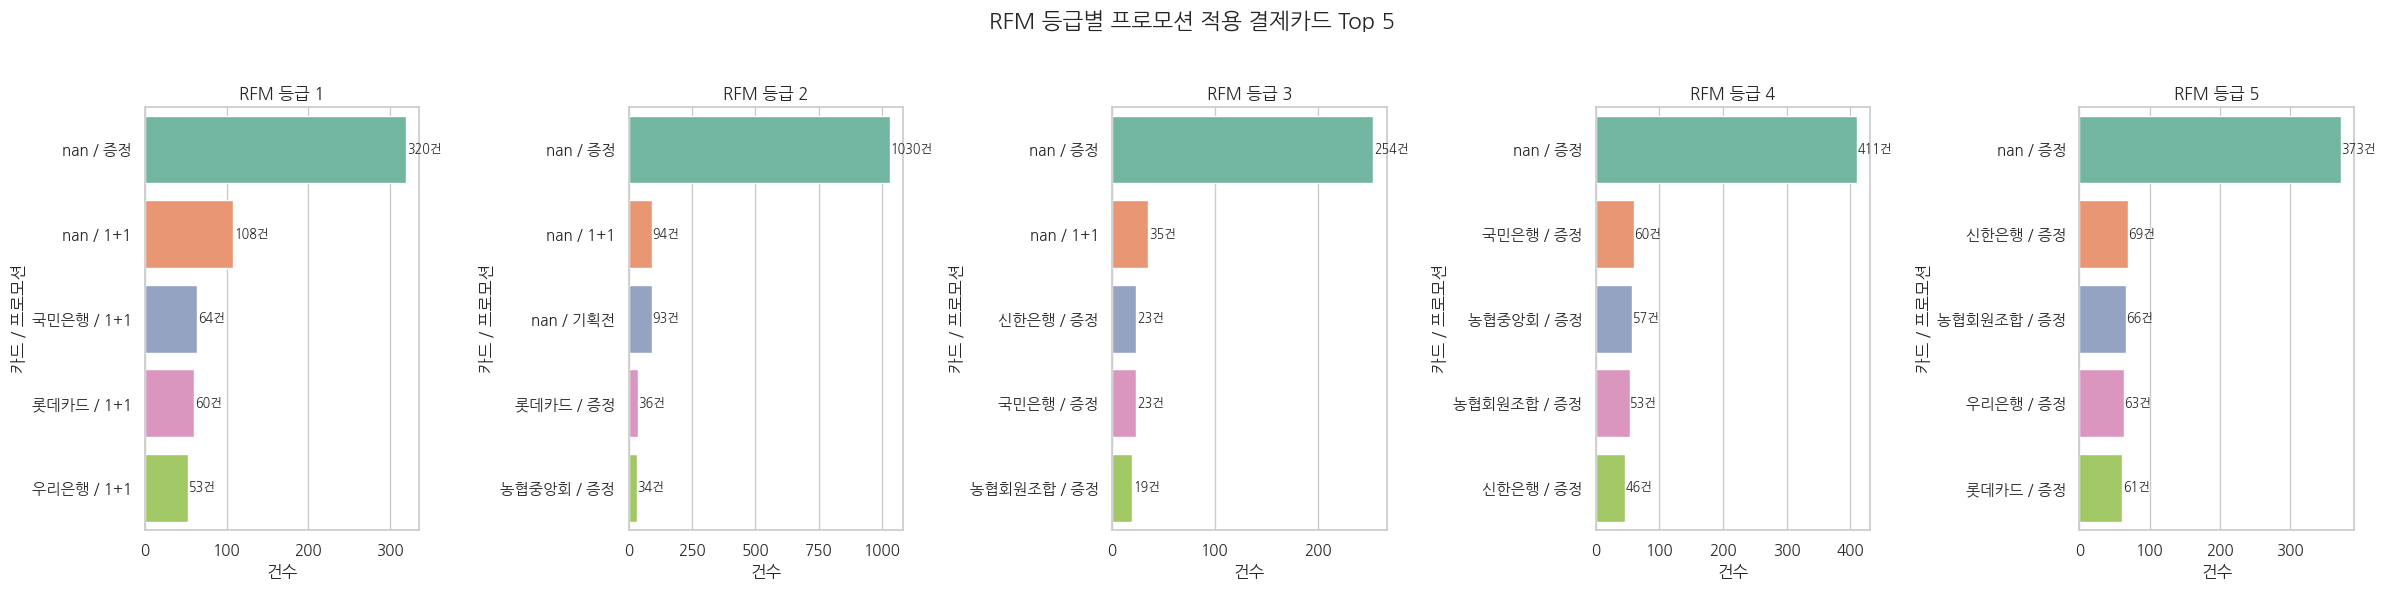

In [150]:
import matplotlib.pyplot as plt
import seaborn as sns
import textwrap


# 🎯 프로모션 적용된 데이터만 사용
df_valid = df[df['프로모션'] != '프로모션 없음'].copy()

# 카드 + 프로모션 조합 라벨 생성
df_valid['카드_프로모션'] = df_valid['결제등록카드'].astype(str) + ' / ' + df_valid['프로모션'].astype(str)

rfm_levels = sorted(df_valid['rfm'].dropna().unique())

fig, axes = plt.subplots(1, len(rfm_levels), figsize=(24, 6), sharey=False)

for i, rfm_level in enumerate(rfm_levels):
    ax = axes[i]
    df_rfm = df_valid[df_valid['rfm'] == rfm_level]

    # 상위 5개 카드/프로모션 조합
    top5_combo = df_rfm['카드_프로모션'].value_counts().head(5).reset_index()
    top5_combo.columns = ['카드_프로모션', '건수']

    # 줄바꿈 처리
    top5_combo['카드_프로모션'] = top5_combo['카드_프로모션'].apply(lambda x: '\n'.join(textwrap.wrap(x, width=15)))

    sns.barplot(data=top5_combo, x='건수', y='카드_프로모션', ax=ax, palette='Set2')

    ax.set_title(f'RFM 등급 {rfm_level}', fontsize=12)
    ax.set_xlabel('건수')
    ax.set_ylabel('카드 / 프로모션')

    # 건수 라벨 표시
    for idx, row in top5_combo.iterrows():
        ax.text(row['건수'] + 1, idx, f"{row['건수']}건", va='center', fontsize=9)

plt.suptitle('RFM 등급별 프로모션 적용 결제카드 Top 5', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()



# 시즌별(4분기) 매출증가율이 감소했다는 것을 증명

In [88]:
# 구매일을 datetime으로 변환 (이미 되어 있으면 생략)
df['구매일'] = pd.to_datetime(df['구매일'])

# 분기 컬럼 생성
df['분기'] = df['구매일'].dt.quarter

In [90]:
# 구매일을 datetime으로 변환 (이미 되어 있으면 생략)
df['구매일'] = pd.to_datetime(df['구매일'])

# 분기 추출
df['분기'] = df['구매일'].dt.quarter

# 분기별 매출 합계 계산
quarter_sales = (
    df.groupby('분기')['결제금액']
    .sum()
    .reset_index(name='총매출')
    .sort_values('분기')
)

# 전 분기 대비 증가율(%) 계산
quarter_sales['증가율(%)'] = quarter_sales['총매출'].pct_change() * 100

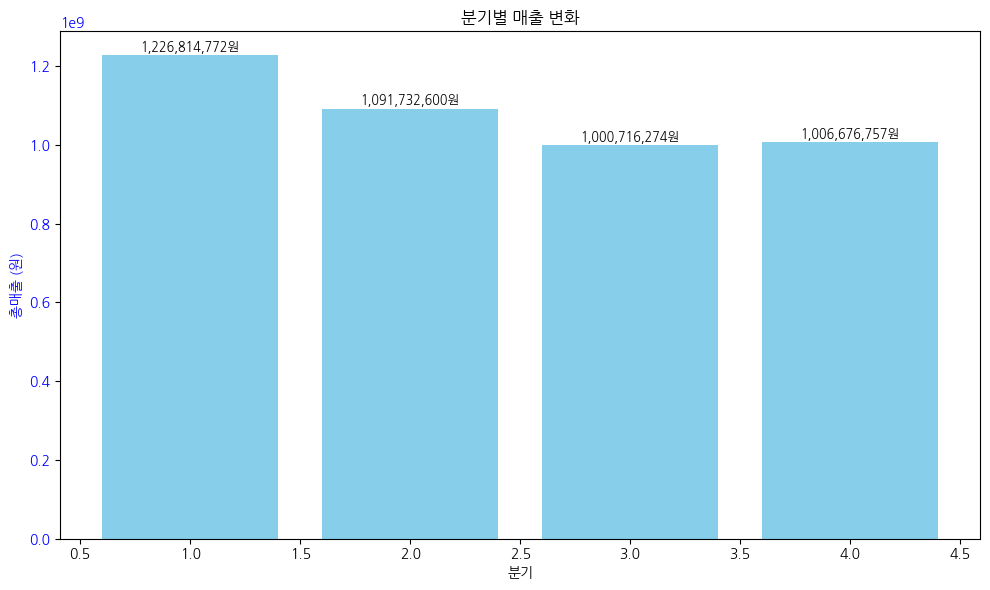

In [96]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(10, 6))

# 막대그래프: 분기별 총매출
bars = ax1.bar(quarter_sales['분기'], quarter_sales['총매출'], color='skyblue', label='총매출')
ax1.set_ylabel('총매출 (원)', color='blue')
ax1.set_xlabel('분기')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_title('분기별 매출 변화')

# 매출 수치 레이블 표시
for bar in bars:
    yval = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2, yval + yval*0.01, f"{int(yval):,}원", ha='center', fontsize=9)

# 오른쪽 축(증가율용 y축) 완전히 제거
# (ax2 생성도 생략함)

plt.tight_layout()
plt.show()

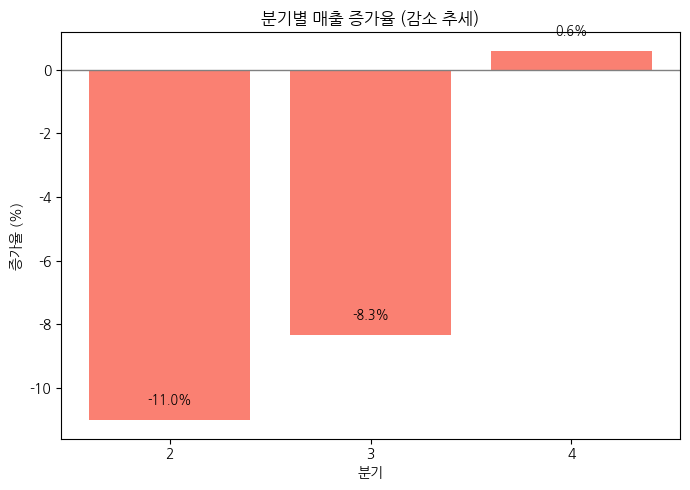

In [95]:
import matplotlib.pyplot as plt

# 증가율만 시각화 (Q2~Q4)
plt.figure(figsize=(7, 5))
plt.bar(quarter_sales['분기'][1:], quarter_sales['증가율(%)'][1:], color='salmon')

for i in range(1, len(quarter_sales)):
    val = quarter_sales.loc[i, '증가율(%)']
    plt.text(quarter_sales.loc[i, '분기'], val + 0.5, f'{val:.1f}%', ha='center', fontsize=9)

plt.axhline(0, color='gray', linewidth=1)
plt.title('분기별 매출 증가율 (감소 추세)')
plt.xlabel('분기')
plt.ylabel('증가율 (%)')
plt.xticks([2, 3, 4])
plt.tight_layout()
plt.show()